In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
#from metpy.io import get_test_data

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [2]:

ds_nosip = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nosip/caipeex_2mom_nosip/NWP_*.nc');
ds_4sip = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/control/caipeex_2mom_sip/NWP_*.nc');
ds_nohm = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nohm/caipeex_2mom_nohm/NWP_*.nc');
ds_norf = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/norf/caipeex_2mom_norf/NWP_*.nc');
ds_nobr = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nobr/caipeex_2mom_nobr/NWP_*.nc');
ds_nosb = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/nosb/caipeex_2mom_nosb/NWP_*.nc');


In [3]:

grid_caipeex = xr.open_dataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/latent_heat/control/caipeex_2mom_sip/domain4_DOM04.nc');

clon_deg = np.degrees(grid_caipeex.clon)
clat_deg = np.degrees(grid_caipeex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([75.5, 17.5])
#print(okla_x), print(okla_y)
dx_deg = 0.5; dy_deg = 0.3
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)


73.96231325070727
78.03733091737507
15.966592379850837
20.032768784756854
75.0
76.0
17.8
17.2


(None, None)

In [4]:

window_cell = (
    (grid_caipeex.clat >= np.deg2rad(bottom_bound))
    & (grid_caipeex.clat <= np.deg2rad(top_bound))
    & (grid_caipeex.clon >= np.deg2rad(left_bound))
    & (grid_caipeex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_caipeex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_caipeex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_caipeex = reindex_grid(grid_caipeex, selected_indices, vars_to_renumber)

mask=np.isin(ds_4sip['ncells'], selected_indices.cell)


window_vertex_indices :: [ 3670  3702  3718 ... 32701 32702 32703]
window_edge_indices :: [11072 11073 11074 ... 95287 95288 95289]


In [5]:

datasets = [ds_nosip, ds_4sip, ds_norf, ds_nohm, ds_nobr, ds_nosb]

ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl

ds_norf['w_vel'] = -1.*ds_norf.omega/(9.8*ds_norf.rho)
ds_norf['tempc'] = ds_norf.temp-273.16;
ds_norf['lwc_gperm3']  = ds_norf.qc*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tqi'] = ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['tq'] = ds_norf.qc+ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['ciwc_gperm3'] = ds_norf.qi*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tiwc_gperm3'] = (ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh)*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['cdnc_percm3'] = ds_norf.qnc*ds_norf.rho*1.e-6  # perkg to percm3
ds_norf['inc_perl'] = (ds_norf.qni+ds_norf.qns+ds_norf.qng+ds_norf.qnh)*ds_norf.rho*1.e-3 # perkg to perl

ds_nohm['w_vel'] = -1.*ds_nohm.omega/(9.8*ds_nohm.rho)
ds_nohm['tempc'] = ds_nohm.temp-273.16;
ds_nohm['lwc_gperm3']  = ds_nohm.qc*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tqi'] = ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['tq'] = ds_nohm.qc+ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['ciwc_gperm3'] = ds_nohm.qi*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tiwc_gperm3'] = (ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh)*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['cdnc_percm3'] = ds_nohm.qnc*ds_nohm.rho*1.e-6  # perkg to percm3
ds_nohm['inc_perl'] = (ds_nohm.qni+ds_nohm.qns+ds_nohm.qng+ds_nohm.qnh)*ds_nohm.rho*1.e-3 # perkg to perl

ds_nobr['w_vel'] = -1.*ds_nobr.omega/(9.8*ds_nobr.rho)
ds_nobr['tempc'] = ds_nobr.temp-273.16;
ds_nobr['lwc_gperm3']  = ds_nobr.qc*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tqi'] = ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['tq'] = ds_nobr.qc+ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['ciwc_gperm3'] = ds_nobr.qi*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tiwc_gperm3'] = (ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh)*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['cdnc_percm3'] = ds_nobr.qnc*ds_nobr.rho*1.e-6  # perkg to percm3
ds_nobr['inc_perl'] = (ds_nobr.qni+ds_nobr.qns+ds_nobr.qng+ds_nobr.qnh)*ds_nobr.rho*1.e-3 # perkg to perl

ds_nosb['w_vel'] = -1.*ds_nosb.omega/(9.8*ds_nosb.rho)
ds_nosb['tempc'] = ds_nosb.temp-273.16;
ds_nosb['lwc_gperm3']  = ds_nosb.qc*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tqi'] = ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['tq'] = ds_nosb.qc+ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['ciwc_gperm3'] = ds_nosb.qi*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tiwc_gperm3'] = (ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh)*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['cdnc_percm3'] = ds_nosb.qnc*ds_nosb.rho*1.e-6  # perkg to percm3
ds_nosb['inc_perl'] = (ds_nosb.qni+ds_nosb.qns+ds_nosb.qng+ds_nosb.qnh)*ds_nosb.rho*1.e-3 # perkg to perl


ht_4avg = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
tempc_4avg = ds_4sip.tempc.mean(dim=('time','ncells'))


In [6]:

aircraft_starttime='2019-09-30T07:00:00.000000000'
aircraft_endtime='2019-09-30T11:00:00.000000000'

ds_nosip_new = ds_nosip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_4sip_new = ds_4sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_norf_new = ds_norf.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nohm_new = ds_nohm.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nobr_new = ds_nobr.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nosb_new = ds_nosb.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [7]:



w_thres = 2.
###### Without SIP
# lwc gperm3
#filt_lwc_up = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_dn = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_st = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)

#lwc_up_nosip = filt_lwc_up.mean(dim=('time','ncells'))
#lwc_dn_nosip = filt_lwc_dn.mean(dim=('time','ncells'))
#lwc_st_nosip = filt_lwc_st.mean(dim=('time','ncells'))

#tempc_nosip = ds_nosip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
#filt_tiwc_up = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_dn = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_st = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.tiwc_gperm3, np.nan)

#tiwc_up_nosip = filt_tiwc_up.mean(dim=('time','ncells'))
#tiwc_dn_nosip = filt_tiwc_dn.mean(dim=('time','ncells'))
#tiwc_st_nosip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
#filt_cdnc_up = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_dn = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_st = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.cdnc_percm3, np.nan)

#cdnc_up_nosip = filt_cdnc_up.mean(dim=('time','ncells'))
#cdnc_dn_nosip = filt_cdnc_dn.mean(dim=('time','ncells'))
#cdnc_st_nosip = filt_cdnc_st.mean(dim=('time','ncells'))

# inc gperm3
#filt_inc_up = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_dn = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_st = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.inc_perl, np.nan)

#inc_up_nosip = filt_inc_up.mean(dim=('time','ncells'))
#inc_dn_nosip = filt_inc_dn.mean(dim=('time','ncells'))
#inc_st_nosip = filt_inc_st.mean(dim=('time','ncells'))


###### With SIP
# lwc gperm3
filt_lwc_up = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_dn = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_st = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)

lwc_up_sip = filt_lwc_up.mean(dim=('time','ncells'))
lwc_dn_sip = filt_lwc_dn.mean(dim=('time','ncells'))
lwc_st_sip = filt_lwc_st.mean(dim=('time','ncells'))

tempc_sip = ds_4sip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_st = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)

tiwc_up_sip = filt_tiwc_up.mean(dim=('time','ncells'))
tiwc_dn_sip = filt_tiwc_dn.mean(dim=('time','ncells'))
tiwc_st_sip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_dn = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_st = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)

cdnc_up_sip = filt_cdnc_up.mean(dim=('time','ncells'))
cdnc_dn_sip = filt_cdnc_dn.mean(dim=('time','ncells'))
cdnc_st_sip = filt_cdnc_st.mean(dim=('time','ncells'))


# inc gperm3
filt_inc_up = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_dn = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_st = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)

inc_up_sip = filt_inc_up.mean(dim=('time','ncells'))
inc_dn_sip = filt_inc_dn.mean(dim=('time','ncells'))
inc_st_sip = filt_inc_st.mean(dim=('time','ncells'))


In [8]:

####================== Boxplot of ICON-LWC [4-SIP]
w_thres = 2.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
lwc_sip_up_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_dn_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_st_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

lwc_sip_up_gperm3 = lwc_sip_up_gperm3.values.flatten()
lwc_sip_dn_gperm3 = lwc_sip_dn_gperm3.values.flatten()
lwc_sip_st_gperm3 = lwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_lwc_sip = pd.DataFrame({
    'lwc_up': lwc_sip_up_gperm3,
    'lwc_dn': lwc_sip_dn_gperm3,
    'lwc_st': lwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_lwc_sip['temp_bin'] = np.digitize(df_lwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_lwc_sip['temp_bin'] = bin_edges[df_lwc_sip['temp_bin']]

df_lwc_up_sip = df_lwc_sip[['lwc_up', 'temp_bin']].dropna()
df_lwc_dn_sip = df_lwc_sip[['lwc_dn', 'temp_bin']].dropna()
df_lwc_st_sip = df_lwc_sip[['lwc_st', 'temp_bin']].dropna()

df_lwc_up_sip = df_lwc_up_sip.dropna(subset=['temp_bin'])
df_lwc_dn_sip = df_lwc_dn_sip.dropna(subset=['temp_bin'])
df_lwc_st_sip = df_lwc_st_sip.dropna(subset=['temp_bin'])

lwc_sip_up_by_bin = [df_lwc_up_sip[df_lwc_up_sip['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
lwc_sip_dn_by_bin = [df_lwc_dn_sip[df_lwc_dn_sip['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
lwc_sip_st_by_bin = [df_lwc_st_sip[df_lwc_st_sip['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]


In [9]:

####================== Boxplot of ICON-CDNC [3-SIP]
w_thres = 2.
thres_q = 1.e-2
###### Without SIP
# lwc gperm3
cdnc_sip_up_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_dn_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_st_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)
tempc_sip = ds_4sip_new.tempc

cdnc_sip_up_percm3 = cdnc_sip_up_percm3.values.flatten()
cdnc_sip_dn_percm3 = cdnc_sip_dn_percm3.values.flatten()
cdnc_sip_st_percm3 = cdnc_sip_st_percm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_cdnc_sip = pd.DataFrame({
    'cdnc_up': cdnc_sip_up_percm3,
    'cdnc_dn': cdnc_sip_dn_percm3,
    'cdnc_st': cdnc_sip_st_percm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_cdnc_sip['temp_bin'] = np.digitize(df_cdnc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_cdnc_sip['temp_bin'] = bin_edges[df_cdnc_sip['temp_bin']]

df_cdnc_up_sip = df_cdnc_sip[['cdnc_up', 'temp_bin']].dropna()
df_cdnc_dn_sip = df_cdnc_sip[['cdnc_dn', 'temp_bin']].dropna()
df_cdnc_st_sip = df_cdnc_sip[['cdnc_st', 'temp_bin']].dropna()

df_cdnc_up_sip = df_cdnc_up_sip.dropna(subset=['temp_bin'])
df_cdnc_dn_sip = df_cdnc_dn_sip.dropna(subset=['temp_bin'])
df_cdnc_st_sip = df_cdnc_st_sip.dropna(subset=['temp_bin'])

cdnc_sip_up_by_bin = [df_cdnc_up_sip[df_cdnc_up_sip['temp_bin'] == temp]['cdnc_up'].values for temp in bin_edges]
cdnc_sip_dn_by_bin = [df_cdnc_dn_sip[df_cdnc_dn_sip['temp_bin'] == temp]['cdnc_dn'].values for temp in bin_edges]
cdnc_sip_st_by_bin = [df_cdnc_st_sip[df_cdnc_st_sip['temp_bin'] == temp]['cdnc_st'].values for temp in bin_edges]


In [10]:

####================== Boxplot of ICON-IWC [3-SIP]
w_thres = 2.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
iwc_sip_up_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_dn_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_st_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

iwc_sip_up_gperm3 = iwc_sip_up_gperm3.values.flatten()
iwc_sip_dn_gperm3 = iwc_sip_dn_gperm3.values.flatten()
iwc_sip_st_gperm3 = iwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_iwc_sip = pd.DataFrame({
    'iwc_up': iwc_sip_up_gperm3,
    'iwc_dn': iwc_sip_dn_gperm3,
    'iwc_st': iwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_iwc_sip['temp_bin'] = np.digitize(df_iwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_iwc_sip['temp_bin'] = bin_edges[df_iwc_sip['temp_bin']]

df_iwc_up_sip = df_iwc_sip[['iwc_up', 'temp_bin']].dropna()
df_iwc_dn_sip = df_iwc_sip[['iwc_dn', 'temp_bin']].dropna()
df_iwc_st_sip = df_iwc_sip[['iwc_st', 'temp_bin']].dropna()

df_iwc_up_sip = df_iwc_up_sip.dropna(subset=['temp_bin'])
df_iwc_dn_sip = df_iwc_dn_sip.dropna(subset=['temp_bin'])
df_iwc_st_sip = df_iwc_st_sip.dropna(subset=['temp_bin'])

iwc_sip_up_by_bin = [df_iwc_up_sip[df_iwc_up_sip['temp_bin'] == temp]['iwc_up'].values for temp in bin_edges]
iwc_sip_dn_by_bin = [df_iwc_dn_sip[df_iwc_dn_sip['temp_bin'] == temp]['iwc_dn'].values for temp in bin_edges]
iwc_sip_st_by_bin = [df_iwc_st_sip[df_iwc_st_sip['temp_bin'] == temp]['iwc_st'].values for temp in bin_edges]


In [11]:

####================== Boxplot of ICON-INC [3-SIP]
w_thres = 2.
thres_q = 1.e-4
###### Without SIP
# lwc gperm3
inc_sip_up_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_dn_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_st_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)
tempc_sip = ds_4sip_new.tempc

inc_sip_up_perl = inc_sip_up_perl.values.flatten()
inc_sip_dn_perl = inc_sip_dn_perl.values.flatten()
inc_sip_st_perl = inc_sip_st_perl.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_inc_sip = pd.DataFrame({
    'inc_up': inc_sip_up_perl,
    'inc_dn': inc_sip_dn_perl,
    'inc_st': inc_sip_st_perl,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_inc_sip['temp_bin'] = np.digitize(df_inc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_inc_sip['temp_bin'] = bin_edges[df_inc_sip['temp_bin']]

df_inc_up_sip = df_inc_sip[['inc_up', 'temp_bin']].dropna()
df_inc_dn_sip = df_inc_sip[['inc_dn', 'temp_bin']].dropna()
df_inc_st_sip = df_inc_sip[['inc_st', 'temp_bin']].dropna()

df_inc_up_sip = df_inc_up_sip.dropna(subset=['temp_bin'])
df_inc_dn_sip = df_inc_dn_sip.dropna(subset=['temp_bin'])
df_inc_st_sip = df_inc_st_sip.dropna(subset=['temp_bin'])

inc_sip_up_by_bin = [df_inc_up_sip[df_inc_up_sip['temp_bin'] == temp]['inc_up'].values for temp in bin_edges]
inc_sip_dn_by_bin = [df_inc_dn_sip[df_inc_dn_sip['temp_bin'] == temp]['inc_dn'].values for temp in bin_edges]
inc_sip_st_by_bin = [df_inc_st_sip[df_inc_st_sip['temp_bin'] == temp]['inc_st'].values for temp in bin_edges]


In [ ]:

tm_range = slice(2743, 2744)
print(data_pip.time[tm_range])
#print(data_pip.Nt_percm3perum[1979:1980].values)
print('value in each bin [percm3] > 400µm :: ',data_pip.iloc[tm_range, 5:61].values)
print()
print('SUM  > 400µm  :: ',np.sum(100.*data_pip.iloc[tm_range, 5:61].values))

In [13]:

## PIP
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/CIP/correctedPbPCIPSizeSpectraCAIPEX20190930.txt'
data_cip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_cip.columns = ['time'] + ['Nt_percm3perum']*62 + ['mass_gpercm']* (data_cip.shape[1]-63) # cols 2-63: n_conc, & remaining 62 columns: mass
##

## PIP
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/PIP/correctedPIPSizeSpectraCAIPEX20190930.txt'
data_pip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_pip.columns = ['time'] + ['Nt_percm3perum']*62 + ['mass_gpercm']* (data_pip.shape[1]-63) # cols 2-63: n_conc, & remaining 62 columns: mass
##

## CIP
diam_cip_end_bin = [15., 30., 45., 60., 75., 90., 105., 120., 135., 150.,
                    165., 180., 195., 210., 225., 240., 255., 270., 285., 300.,
                    315., 330., 345., 360., 375., 390., 405., 420., 435., 450., 
                    465., 480., 495., 510., 525., 540., 555., 570., 585., 600.,
                    615., 630., 645., 660., 675., 690., 705., 720., 735., 750.,
                    765., 780., 795., 810., 825., 840., 855., 870., 885., 900.,
                    915., 930.]
##

## PIP
diam_pip_end_bin = [100., 200., 300., 400., 500., 600., 700., 800., 900., 1000.,
                    1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000.,
                    2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800., 2900., 3000.,
                    3100., 3200., 3300., 3400., 3500., 3600., 3700., 3800., 3900., 4000.,
                    4100., 4200., 4300., 4400., 4500., 4600., 4700., 4800., 4900., 5000.,
                    5100., 5200., 5300., 5400., 5500., 5600., 5700., 5800., 5900., 6000.,
                    6100., 6200.]
## 

#diam_cip_width_um = np.diff(diam_cip_bin_um)
#diam_cip_width_cm = np.diff(diam_cip_bin_cm)

## CIP
diam_cip_bin_um = np.array(diam_cip_end_bin)
diam_cip_bin_cm = 1.e-4*np.array(diam_cip_end_bin)

nt_cip_percm3perum = data_cip.iloc[:,1:63].values
mt_cip_gpercm = data_cip.iloc[:,63:].values
##

## PIP
diam_pip_bin_um = np.array(diam_pip_end_bin)
diam_pip_bin_m = 1.e-6*diam_pip_bin_um
diam_pip_bin_cm = 1.e-4*np.array(diam_pip_end_bin)

nt_pip_percm3percm = data_pip.iloc[:,1:63].values
nt_pip_perm3perm = 1.e5*data_pip.iloc[:,1:63].values  # only for check (From Dr. Sachin Patade, netcdf file screenshot)
mt_pip_gpercm = data_pip.iloc[:,63:].values
##

##============================================ CIP
cip_nt_mask = (nt_cip_percm3perum > 0.)
mask_cip_diam_um = (np.array(diam_cip_end_bin) > 400.)
cip_mt_mask = (mt_cip_gpercm > 0.) 

diam_cip_bin_width_um = 15.    # µm
diam_cip_bin_width_cm = 15.e-4 # cm

nice_cip_percm3 = np.where(cip_nt_mask & mask_cip_diam_um, nt_cip_percm3perum* diam_cip_bin_width_um, np.nan)
#mice_cip_gperm3 = np.where(cip_mt_mask & mask_cip_diam_um, mt_cip_gpercm/(diam_cip_bin_width_cm**2.), np.nan)

nice_cip_percm3 = np.nansum(nice_cip_percm3, axis=1)
#mice_cip_percm3 = np.nansum(mice_cip_gperm3, axis=1)

nice400um_cip_perl = 1.e3*nice_cip_percm3

# Store required variables in as a new dataset  
ds_cip = pd.DataFrame()
ds_cip['time'] = data_cip['time']
ds_cip['ni400um_cip_perl'] = pd.Series(nice400um_cip_perl)
##============================================

##============================================ PIP
pip_nt_mask = (nt_pip_percm3percm > 0.) #& (nt_pip_percm3perum < 1.0) 
mask_pip_diam_um = (np.array(diam_pip_end_bin) > 400.)
mask_pip_diam_m = (diam_pip_bin_m > 400.e-6)
mask_pip_diam_cm = (diam_pip_bin_m > 400.e-4)
pip_mt_mask = (mt_pip_gpercm > 0.) 

diam_pip_bin_width_m = 100*1.e-6 # m
diam_pip_bin_width_um = 100. # µm
diam_pip_bin_width_cm = 100*1.e-4 # cm

nice_pip_percm3 = np.where(pip_nt_mask & mask_pip_diam_m, nt_pip_percm3percm * diam_pip_bin_width_cm, np.nan)
nice_pip_perm3 = np.where(pip_nt_mask & mask_pip_diam_m, nt_pip_perm3perm * diam_pip_bin_width_m, np.nan)  # only for check
#mice_pip_gperm3 = np.where(pip_mt_mask & mask_pip_diam_um, mt_pip_gpercm/(diam_pip_bin_width_cm**2.), np.nan)

nice_pip_percm3 = np.nansum(nice_pip_percm3, axis=1)
nice_pip_perm3 = np.nansum(nice_pip_perm3, axis=1)
#mice_cip_percm3 = np.nansum(mice_cip_gperm3, axis=1)

nice400um_pip_perl = 1.e3*nice_pip_percm3

# Store required variables in as a new dataset  
ds_pip = pd.DataFrame()
ds_pip['time'] = data_pip['time']
ds_pip['ni400um_pip_perl'] = pd.Series(nice400um_pip_perl)
##============================================

#plt.plot(ds_cip.time,ds_cip.nice400um_cip_perl)

In [14]:
diam_pip_bin_cm

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62])

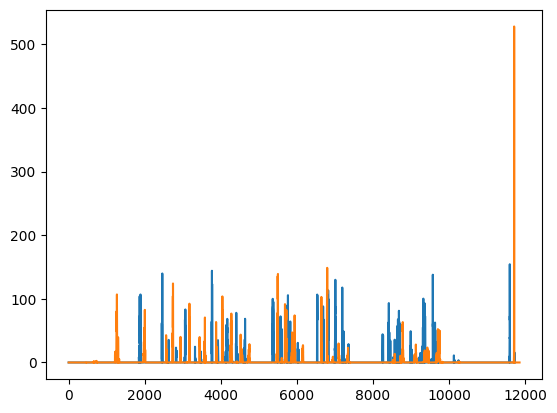

In [15]:
#plt.plot(nice400um_cip_perl)
#plt.plot(1.e-3*nice_pip_perm3)
#plt.plot(nt_pip_percm3percm)
plt.plot(ds_cip.ni400um_cip_perl)
plt.plot(ds_pip.ni400um_pip_perl)
#plt.ylim(1.e0,2.e6)
#plt.plot(nt_cip_percm3perum)
#plt.plot(nice_cip_percm3)

In [16]:

# Flight data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/aa_CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_v2.columns = ['time', 'alt', 'lon', 'lat', 'air_speed', 
                   'air_temp', 'pres', 'rel_hum', 'wind_spped', 'wind_dir',
                   'vert_vel', 'num_conc_ccp_cdp', 'lwc_conc_ccp_cdp', 'mean_vol_diam_ccp_cdp', 'ccn200ass',
                   'ccn200anumconc', 'ccn200bss', 'ccn200bnumconc', 'num_conc_cdp', 'lwc_conc_cdp',
                   'mean_vol_diam_cdp', 'num_conc_cip', 'lwc_conc_cip', 'mean_vol_diam_cip', 'num_conc_pcasp',
                   'mass_conc_pcasp', 'mean_vol_diam_pcasp', 'num_conc_pip', 'lwc_conc_pip', 'mean_vol_diam_pip', 
                   'num_conc_sp2', 'mass_conc_sp2', 'mean_vol_diam_sp2', 'num_conc_sp2rbc', 'mass_conc_sp2rbc',  
                   'mean_vol_diam_sp2rbc', 'num_conc_uhsas', 'mass_conc_uhsas', 'mean_vol_diam_uhsas', 'lwc_300']

#df_v2 = pd.DataFrame(data_v2)
#df_v2['num_conc_cip'] = pd.to_numeric(df_v2['num_conc_cip'], errors='coerce')
data_v2['tempc'] = data_v2['air_temp']
ds_v2 = data_v2
ds_v2['nice_cip_up'] = np.where(ds_v2.num_conc_cip > 0., ds_v2.num_conc_cip, np.nan)

# CDNC
ds_v2['cdnc_cdp_up_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (ds_v2.vert_vel > 2.), ds_v2.num_conc_cdp, np.nan)
ds_v2['cdnc_cdp_dn_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (ds_v2.vert_vel < -2.), ds_v2.num_conc_cdp, np.nan)
ds_v2['cdnc_cdp_st_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (np.abs(ds_v2.vert_vel) < 2.), ds_v2.num_conc_cdp, np.nan)

# LWC
ds_v2['lwc_cdp_up_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (ds_v2.vert_vel > 2.) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)
ds_v2['lwc_cdp_dn_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (ds_v2.vert_vel < -2.) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)
ds_v2['lwc_cdp_st_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (np.abs(ds_v2.vert_vel) < 2.) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)

temp_bin = np.arange(-30, 30, 5)
temp_bin = np.sort(temp_bin)

ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)


ds_v2 = ds_v2.dropna(subset=['temp_bin'])

ds_v2['temp_bin'] = ds_v2['temp_bin'].astype(float)

## Combine ds_v2 and ds_cip data for ds_v2.time=ds_cip.time
##=========== PIP
ds_v2_cip_comb = pd.merge(ds_v2, ds_cip, on='time', how='inner')

##=========== PIP
ds_v2_pip_comb = pd.merge(ds_v2, ds_pip, on='time', how='inner')

# TINC
##=========== CIP
ds_v2_cip_comb['ni400um_cip_up_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-3) & (ds_v2_cip_comb.vert_vel > 2.), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)
ds_v2_cip_comb['ni400um_cip_dn_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-3) & (ds_v2_cip_comb.vert_vel < -2.), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)
ds_v2_cip_comb['ni400um_cip_st_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-3) & (np.abs(ds_v2_cip_comb.vert_vel) < 2.), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)

##=========== PIP
ds_v2_pip_comb['ni400um_pip_up_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-3) & (ds_v2_pip_comb.vert_vel > 2.), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)
ds_v2_pip_comb['ni400um_pip_dn_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-3) & (ds_v2_pip_comb.vert_vel < -2.), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)
ds_v2_pip_comb['ni400um_pip_st_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-3) & (np.abs(ds_v2_pip_comb.vert_vel) < 2.), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)


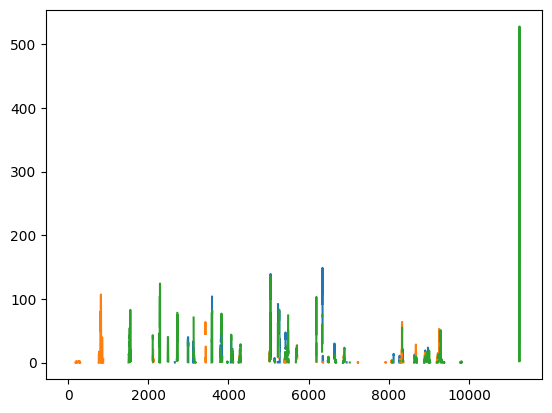

In [17]:
plt.plot(ds_v2_pip_comb.ni400um_pip_up_perl)
plt.plot(ds_v2_pip_comb.ni400um_pip_dn_perl)
plt.plot(ds_v2_pip_comb.ni400um_pip_st_perl)


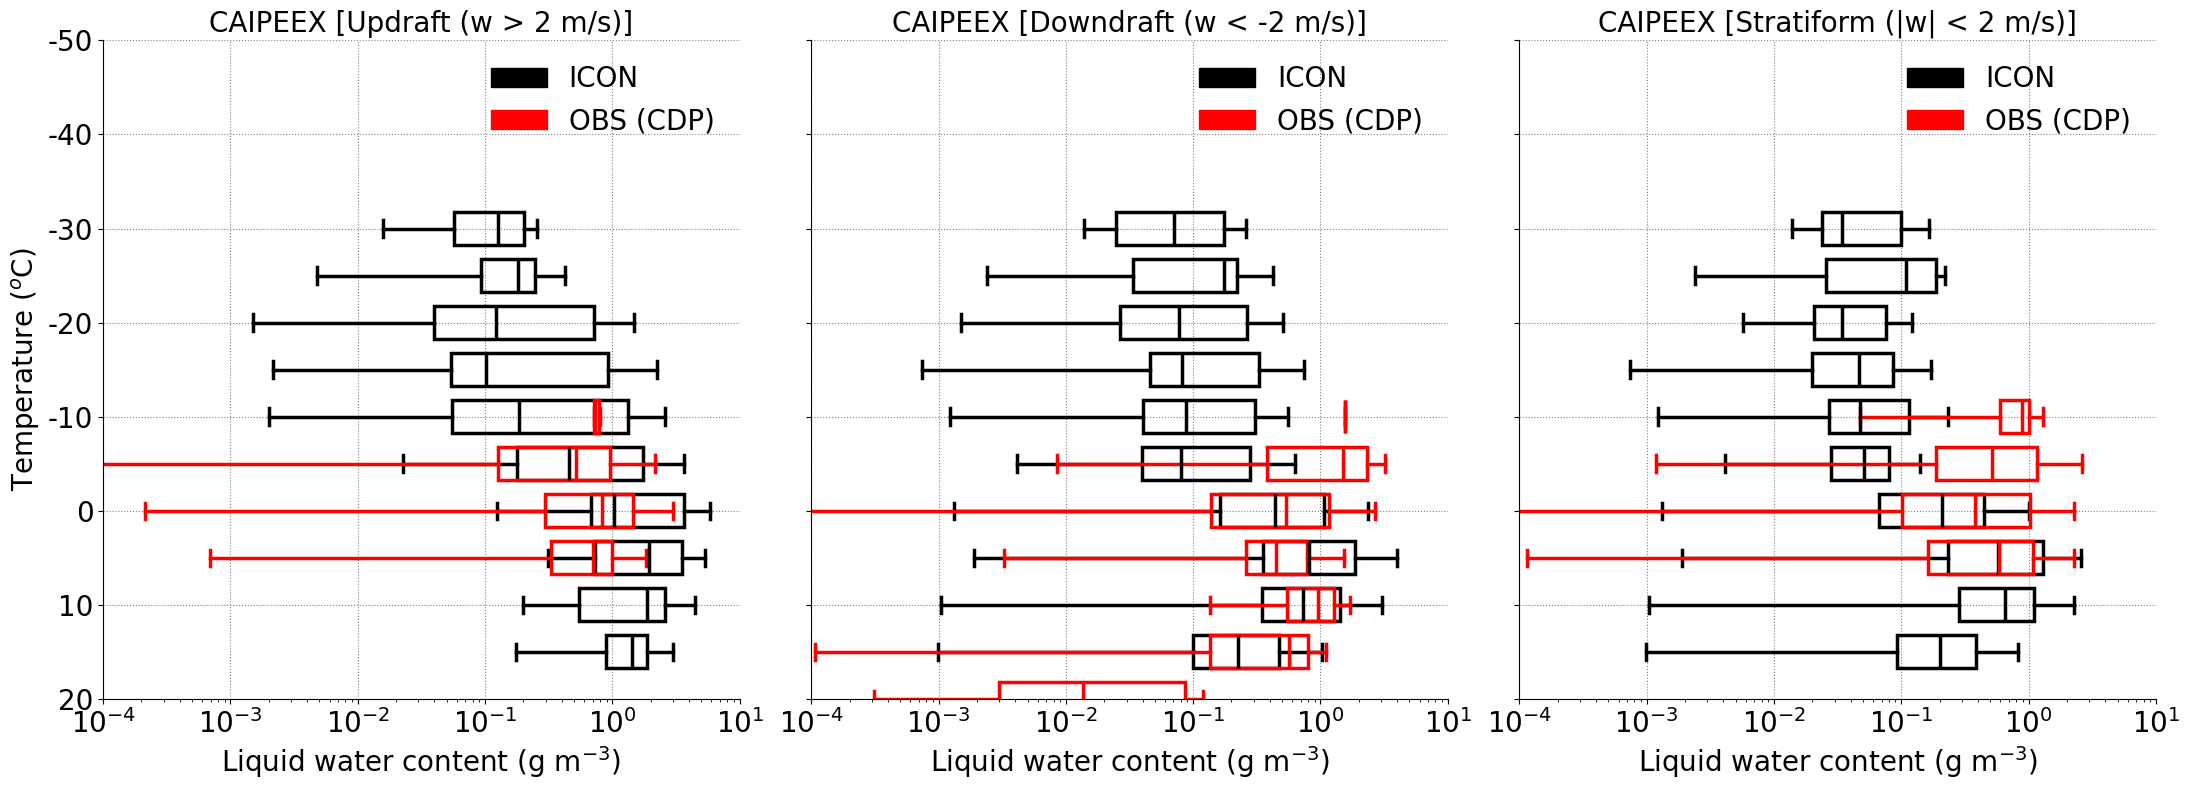

In [18]:


df_v2 = pd.DataFrame(ds_v2)


temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)

df_v2['temp_cdp_bin'] = np.digitize(df_v2['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2['temp_bin'] = bin_edges[df_v2['temp_cdp_bin']]

# LWC
df_lwc_up_cdp = df_v2[['lwc_cdp_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_cdp = df_v2[['lwc_cdp_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_cdp = df_v2[['lwc_cdp_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_cdp = df_lwc_up_cdp.dropna(subset=['temp_bin'])
df_lwc_dn_cdp = df_lwc_dn_cdp.dropna(subset=['temp_bin'])
df_lwc_st_cdp = df_lwc_st_cdp.dropna(subset=['temp_bin'])

lwc_cdp_up_by_bin = [df_lwc_up_cdp[df_lwc_up_cdp['temp_bin'] == temp]['lwc_cdp_up_gperm3'].values for temp in bin_edges]
lwc_cdp_dn_by_bin = [df_lwc_dn_cdp[df_lwc_dn_cdp['temp_bin'] == temp]['lwc_cdp_dn_gperm3'].values for temp in bin_edges]
lwc_cdp_st_by_bin = [df_lwc_st_cdp[df_lwc_st_cdp['temp_bin'] == temp]['lwc_cdp_st_gperm3'].values for temp in bin_edges]

# CDNC
df_cdnc_up_cdp = df_v2[['cdnc_cdp_up_percm3', 'temp_bin']].dropna()
df_cdnc_dn_cdp = df_v2[['cdnc_cdp_dn_percm3', 'temp_bin']].dropna()
df_cdnc_st_cdp = df_v2[['cdnc_cdp_st_percm3', 'temp_bin']].dropna()

df_cdnc_up_cdp = df_cdnc_up_cdp.dropna(subset=['temp_bin'])
df_cdnc_dn_cdp = df_cdnc_dn_cdp.dropna(subset=['temp_bin'])
df_cdnc_st_cdp = df_cdnc_st_cdp.dropna(subset=['temp_bin'])

cdnc_cdp_up_by_bin = [df_cdnc_up_cdp[df_cdnc_up_cdp['temp_bin'] == temp]['cdnc_cdp_up_percm3'].values for temp in bin_edges]
cdnc_cdp_dn_by_bin = [df_cdnc_dn_cdp[df_cdnc_dn_cdp['temp_bin'] == temp]['cdnc_cdp_dn_percm3'].values for temp in bin_edges]
cdnc_cdp_st_by_bin = [df_cdnc_st_cdp[df_cdnc_st_cdp['temp_bin'] == temp]['cdnc_cdp_st_percm3'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(lwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(lwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(lwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        
        ax.boxplot(lwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e1)
    ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(20, -50)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)
#axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
#axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

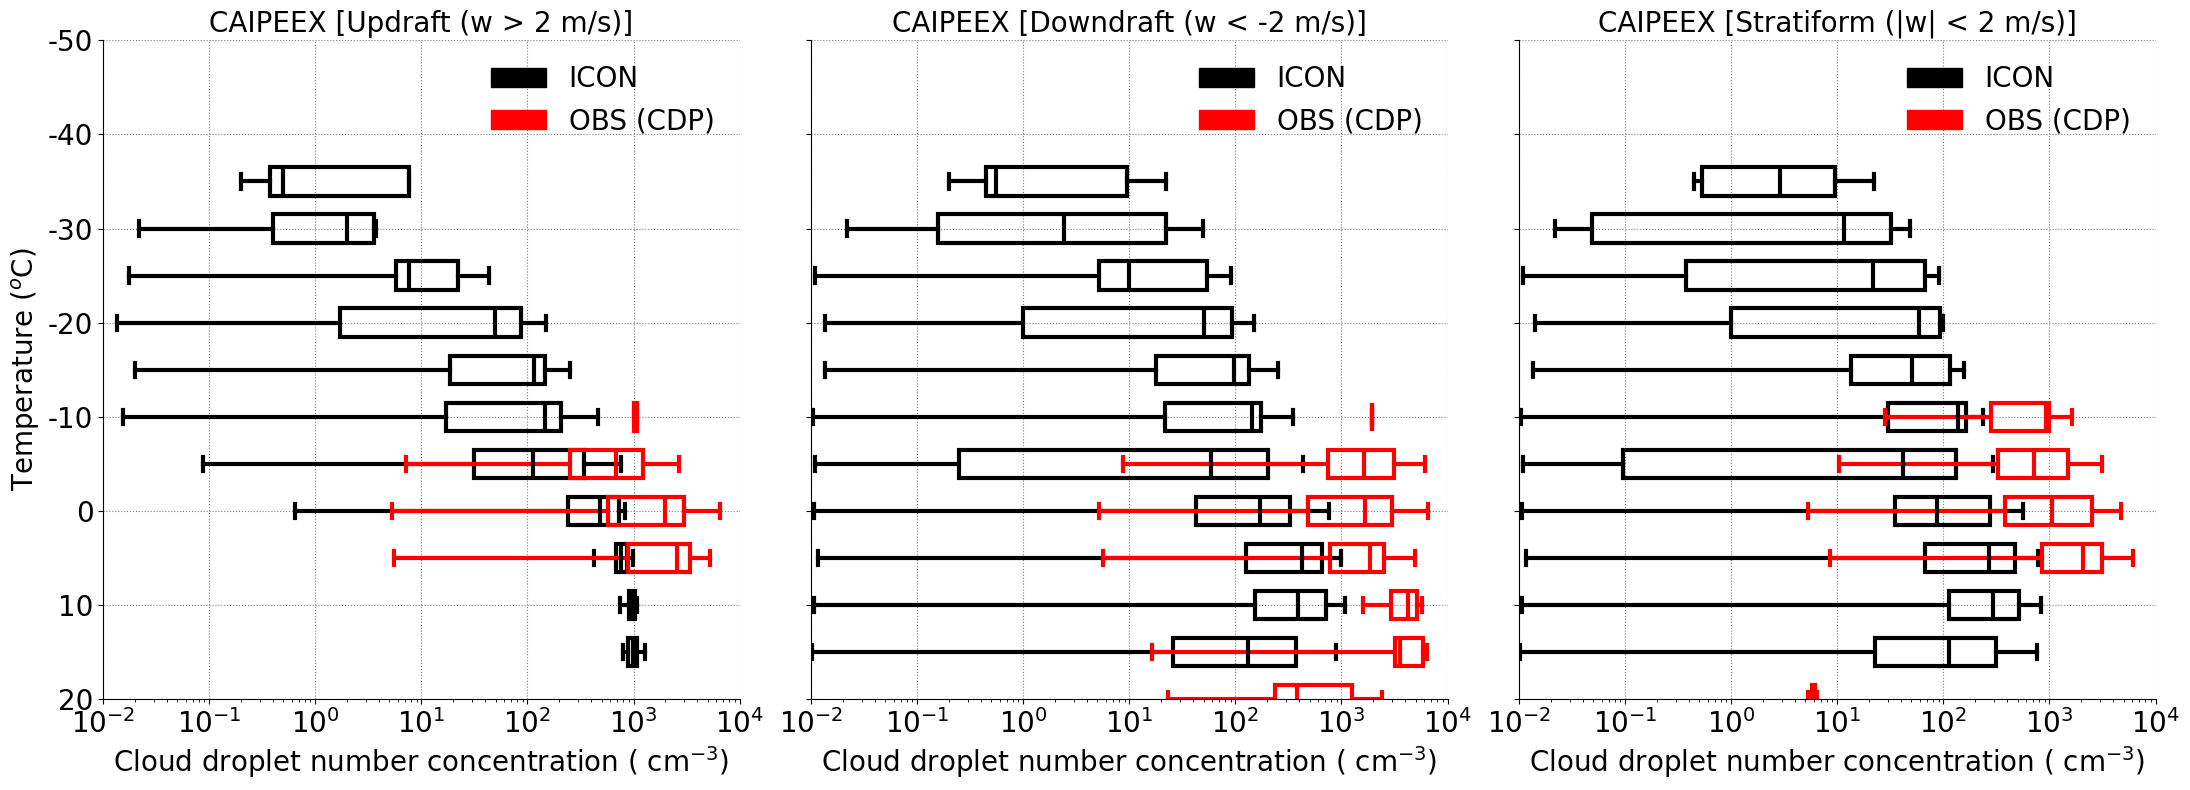

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=3
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(cdnc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e4)
    ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
    ax.set_ylim(20, -50)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud droplet number concentration ( cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)
#axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
#axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

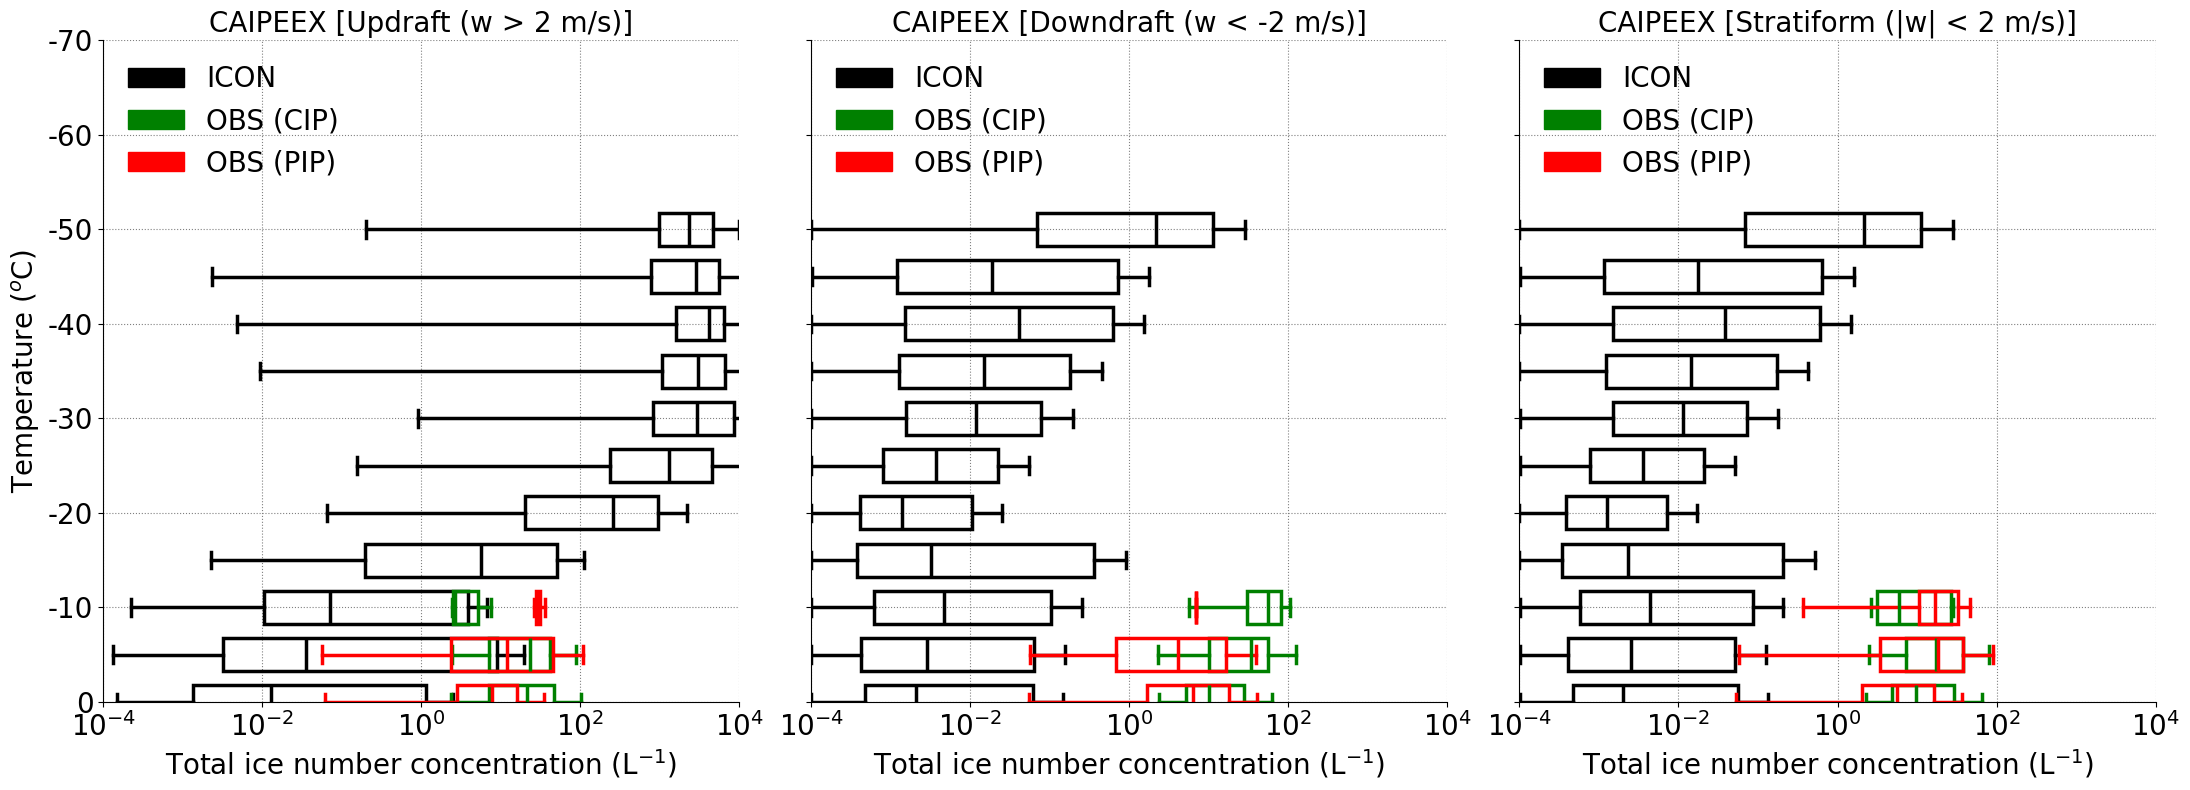

In [20]:

## Total ice number concentrations (CIP & PIP > 400µm)
##=============== CIP
df_v2_cip_comb = pd.DataFrame(ds_v2_cip_comb)

#temp_cip_bin = np.arange(-20, 0, 3)
temp_cip_bin = np.arange(-20, 20, 5)
temp_cip_bin = np.sort(temp_cip_bin)

df_v2_cip_comb['temp_cip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_cip_bin, right=False)

bin_edges = np.concatenate([temp_cip_bin - 2, [temp_cip_bin[-1] + 2]])  
df_v2_cip_comb['temp_bin'] = bin_edges[df_v2_cip_comb['temp_cip_bin']]

# TINC
df_nice_up_cip = df_v2_cip_comb[['ni400um_cip_up_perl', 'temp_bin']].dropna()
df_nice_dn_cip = df_v2_cip_comb[['ni400um_cip_dn_perl', 'temp_bin']].dropna()
df_nice_st_cip = df_v2_cip_comb[['ni400um_cip_st_perl', 'temp_bin']].dropna()

df_nice_up_cip = df_nice_up_cip.dropna(subset=['temp_bin'])
df_nice_dn_cip = df_nice_dn_cip.dropna(subset=['temp_bin'])
df_nice_st_cip = df_nice_st_cip.dropna(subset=['temp_bin'])

inc_cip_up_by_bin = [df_nice_up_cip[df_nice_up_cip['temp_bin'] == temp]['ni400um_cip_up_perl'].values for temp in bin_edges]
inc_cip_dn_by_bin = [df_nice_dn_cip[df_nice_dn_cip['temp_bin'] == temp]['ni400um_cip_dn_perl'].values for temp in bin_edges]
inc_cip_st_by_bin = [df_nice_st_cip[df_nice_st_cip['temp_bin'] == temp]['ni400um_cip_st_perl'].values for temp in bin_edges]


##=============== PIP
df_v2_pip_comb = pd.DataFrame(ds_v2_pip_comb)

#temp_pip_bin = np.arange(-20, 0, 3)
temp_pip_bin = np.arange(-20, 20, 5)
temp_pip_bin = np.sort(temp_pip_bin)

df_v2_pip_comb['temp_pip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
df_v2_pip_comb['temp_bin'] = bin_edges[df_v2_pip_comb['temp_pip_bin']]

# TINC
df_nice_up_pip = df_v2_pip_comb[['ni400um_pip_up_perl', 'temp_bin']].dropna()
df_nice_dn_pip = df_v2_pip_comb[['ni400um_pip_dn_perl', 'temp_bin']].dropna()
df_nice_st_pip = df_v2_pip_comb[['ni400um_pip_st_perl', 'temp_bin']].dropna()

df_nice_up_pip = df_nice_up_pip.dropna(subset=['temp_bin'])
df_nice_dn_pip = df_nice_dn_pip.dropna(subset=['temp_bin'])
df_nice_st_pip = df_nice_st_pip.dropna(subset=['temp_bin'])

inc_pip_up_by_bin = [df_nice_up_pip[df_nice_up_pip['temp_bin'] == temp]['ni400um_pip_up_perl'].values for temp in bin_edges]
inc_pip_dn_by_bin = [df_nice_dn_pip[df_nice_dn_pip['temp_bin'] == temp]['ni400um_pip_dn_perl'].values for temp in bin_edges]
inc_pip_st_by_bin = [df_nice_st_pip[df_nice_st_pip['temp_bin'] == temp]['ni400um_pip_st_perl'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        #ax.plot(inc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_up_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_dn_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_st_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e4)
    ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -70)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (L$^{-1 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='green', label='OBS (CIP)')
    obs_patch3 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2, obs_patch3], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

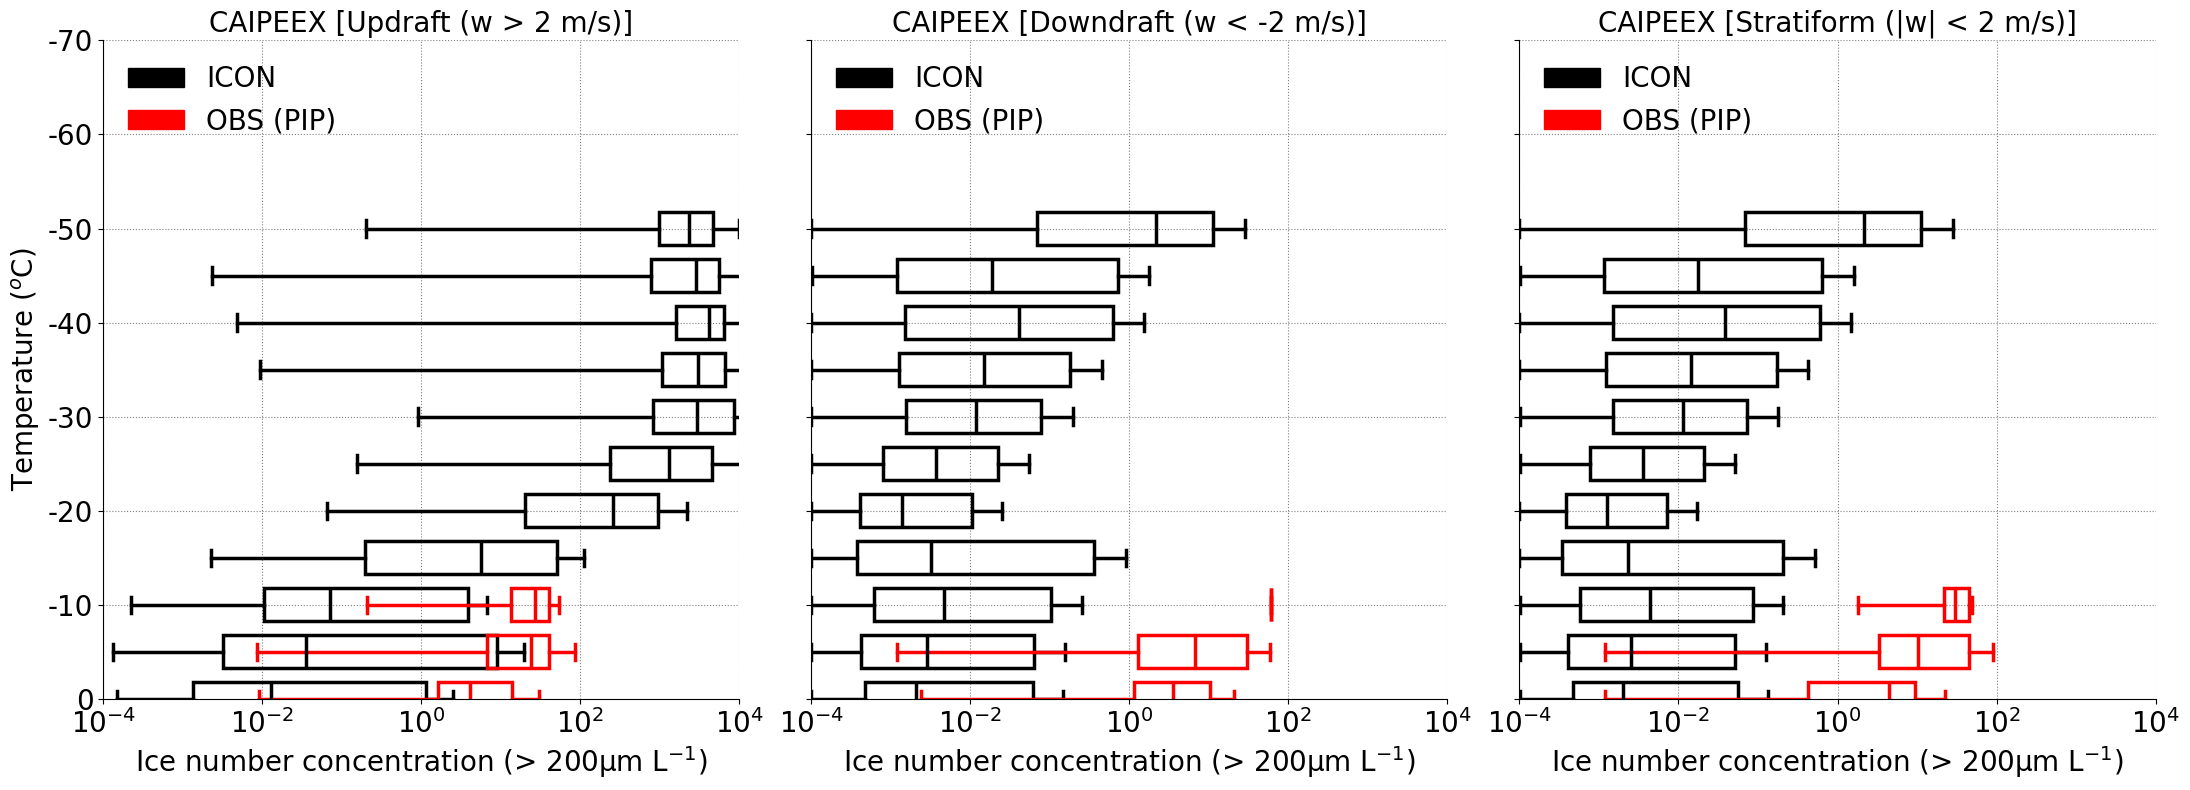

In [21]:

ds_pip_nc = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/PIP/09302019_000000_PIP.nc');

data_pip = pd.DataFrame()
data_pip['time'] = ds_pip_nc['utc_time']
data_pip['NT100'] = ds_pip_nc['NT100']
data_pip['NT200'] = ds_pip_nc['NT200']
data_pip['IWC100'] = ds_pip_nc['IWC100']
data_pip['IWC200'] = ds_pip_nc['IWC200']
data_pip['NT200_perl'] = 1.e-3*ds_pip_nc['NT200']

data_v2_pip_comb = pd.merge(ds_v2, data_pip, on='time', how='inner')

##=========== PIP TINC
data_v2_pip_comb['ni200um_pip_up_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (data_v2_pip_comb.vert_vel > 2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
data_v2_pip_comb['ni200um_pip_dn_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (data_v2_pip_comb.vert_vel < -2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
data_v2_pip_comb['ni200um_pip_st_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (np.abs(data_v2_pip_comb.vert_vel) < 2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
##=========== PIP IWC
data_v2_pip_comb['iwc_pip_up_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel > 2.), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_dn_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel < -2.), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_st_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (np.abs(data_v2_pip_comb.vert_vel) < 2.), 
                                        data_v2_pip_comb.IWC200, np.nan)

##=============== PIP
data_v2_pip_comb = pd.DataFrame(data_v2_pip_comb)

#temp_pip_bin = np.arange(-20, 0, 3)
temp_pip_bin = np.arange(-20, 20, 5)
temp_pip_bin = np.sort(temp_pip_bin)

data_v2_pip_comb['temp_pip_bin'] = np.digitize(data_v2_pip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
data_v2_pip_comb['temp_bin'] = bin_edges[data_v2_pip_comb['temp_pip_bin']]

# PIP-TINC
df_ni200_up_pip = data_v2_pip_comb[['ni200um_pip_up_perl', 'temp_bin']].dropna()
df_ni200_dn_pip = data_v2_pip_comb[['ni200um_pip_dn_perl', 'temp_bin']].dropna()
df_ni200_st_pip = data_v2_pip_comb[['ni200um_pip_st_perl', 'temp_bin']].dropna()

df_ni200_up_pip = df_ni200_up_pip.dropna(subset=['temp_bin'])
df_ni200_dn_pip = df_ni200_dn_pip.dropna(subset=['temp_bin'])
df_ni200_st_pip = df_ni200_st_pip.dropna(subset=['temp_bin'])

inc200_pip_up_by_bin = [df_ni200_up_pip[df_ni200_up_pip['temp_bin'] == temp]['ni200um_pip_up_perl'].values for temp in bin_edges]
inc200_pip_dn_by_bin = [df_ni200_dn_pip[df_ni200_dn_pip['temp_bin'] == temp]['ni200um_pip_dn_perl'].values for temp in bin_edges]
inc200_pip_st_by_bin = [df_ni200_st_pip[df_ni200_st_pip['temp_bin'] == temp]['ni200um_pip_st_perl'].values for temp in bin_edges]

# PIP-IWC
df_iwc_up_pip = data_v2_pip_comb[['iwc_pip_up_gperm3', 'temp_bin']].dropna()
df_iwc_dn_pip = data_v2_pip_comb[['iwc_pip_dn_gperm3', 'temp_bin']].dropna()
df_iwc_st_pip = data_v2_pip_comb[['iwc_pip_st_gperm3', 'temp_bin']].dropna()

df_iwc_up_pip = df_iwc_up_pip.dropna(subset=['temp_bin'])
df_iwc_dn_pip = df_iwc_dn_pip.dropna(subset=['temp_bin'])
df_iwc_st_pip = df_iwc_st_pip.dropna(subset=['temp_bin'])

iwc_pip_up_by_bin = [df_iwc_up_pip[df_iwc_up_pip['temp_bin'] == temp]['iwc_pip_up_gperm3'].values for temp in bin_edges]
iwc_pip_dn_by_bin = [df_iwc_dn_pip[df_iwc_dn_pip['temp_bin'] == temp]['iwc_pip_dn_gperm3'].values for temp in bin_edges]
iwc_pip_st_by_bin = [df_iwc_st_pip[df_iwc_st_pip['temp_bin'] == temp]['iwc_pip_st_gperm3'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        #ax.plot(inc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc200_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc200_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(inc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc200_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e4)
    ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -70)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice number concentration (> 200µm L$^{-1 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

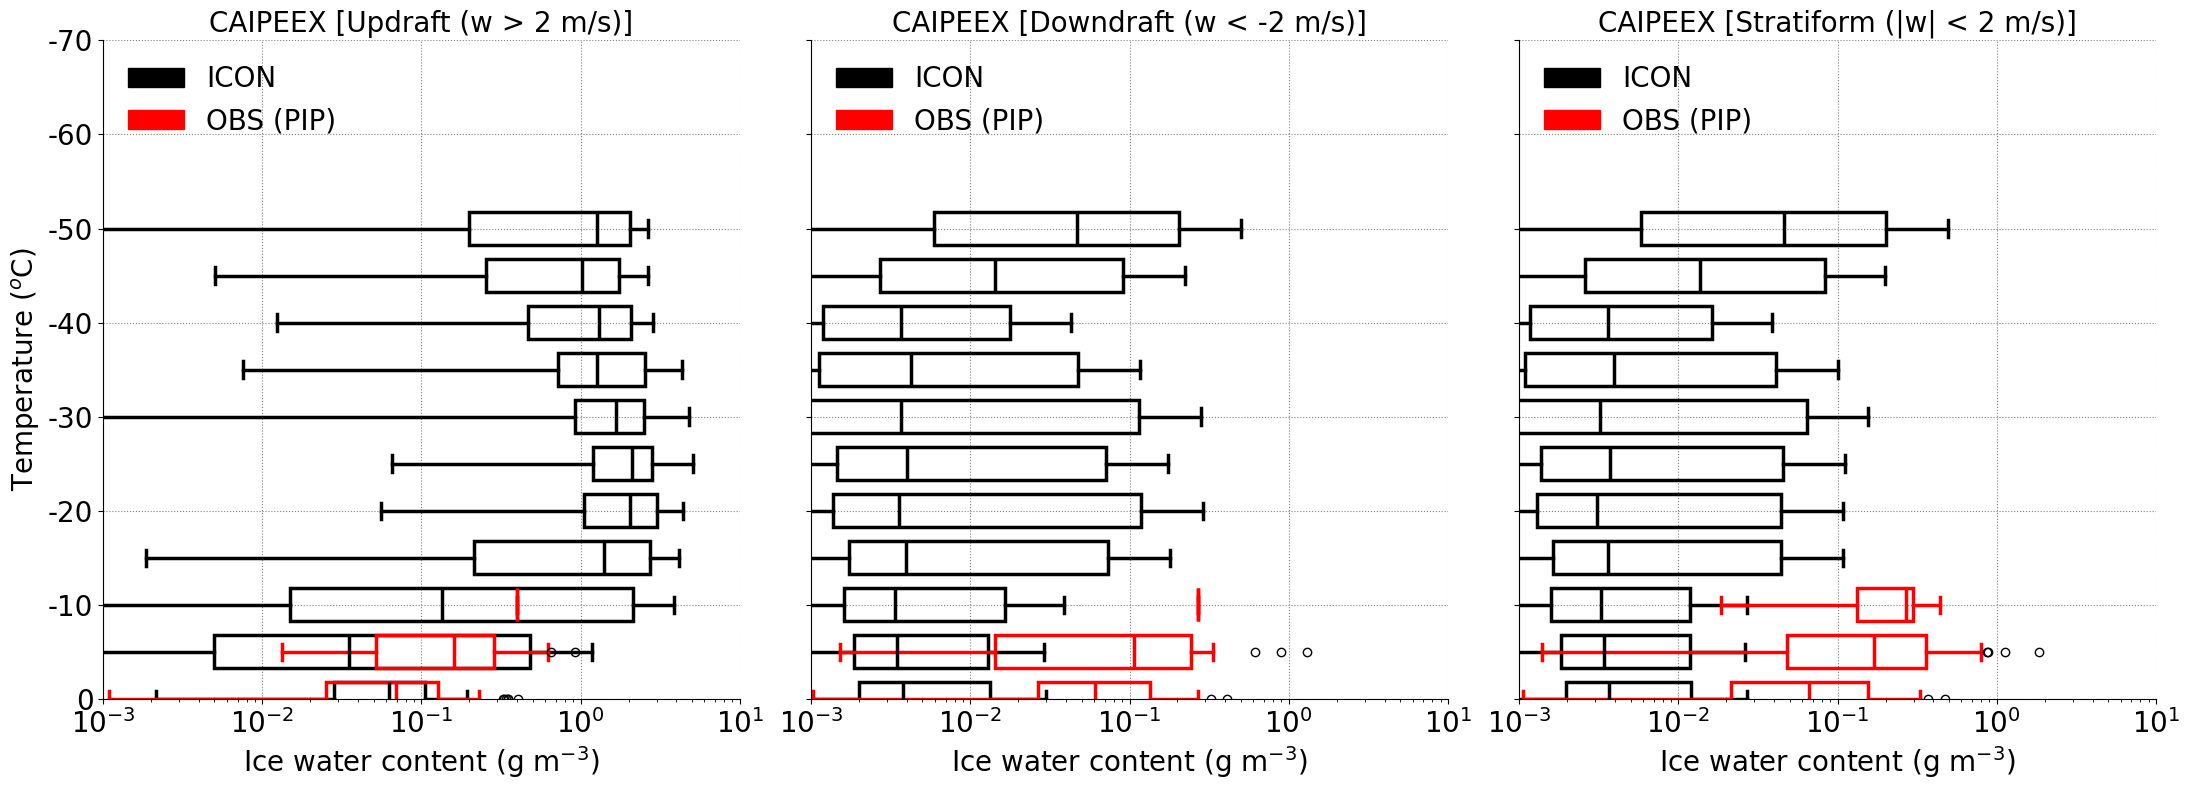

In [22]:

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEEX [Updraft (w > 2 m/s)]', 'CAIPEEX [Downdraft (w < -2 m/s)]', 'CAIPEEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha=1;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        #ax.plot(tiwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   showfliers=False)
        
        ax.boxplot(iwc_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha1))
        
    elif i == 1:
        #ax.plot(tiwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   showfliers=False)
        
        ax.boxplot(iwc_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha1))
    
    elif i == 2:
        #ax.plot(tiwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha),
                   showfliers=False)
        
        ax.boxplot(iwc_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha1))

    ax.set_xscale('log')
    ax.set_xlim(1.e-3, 1.e1)
    ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(0, -70)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [24]:

def calc_dewpoint(tempc, rh):
    dewpoint = tempc - ((100. - rh)/5.)
    return dewpoint

def calc_vir_temp(tc, q):
    #virt_tempk_wk = t/(1. - (ev/p)*(1-0.622))
    temp = tc + (1-0.622*q)
    return temp
    
def calculate_lcl(pressure, temperature, dewpoint):
    l = np.argmin(np.abs(temperature - dewpoint))
    return pressure[l], temperature[l]
    
def e_sat_hpa(tc):
    e_sat_pa = 6.112*np.exp((17.67*tc)/(tc+243.5))
    return e_sat_pa

def calc_parcel_temp(pres, ht, q_sat, tk_lcl):
    grav = 9.8  # acceleration due to gravity [m/s^2]
    eps = 0.622  # ratio of the gas constants for water vapor and dry air
    Rd = 287.  # specific gas constant for dry air [J/(kg*K)]
    cp = 1005.  # specific heat capacity at constant pressure for dry air [J/(kg*K)]
    lv = 2.5e6  # latent heat of vaporization [J/kg]
    Rv = 461.  # specific gas constant for water vapor [J/(kg*K)]

    tk_parcel = np.zeros(len(ht))  
    del_t_par = np.zeros(len(ht))  

    tk_parcel[0] = tk_lcl + 273.15 
    
    for i in range(1, len(ht)):
        dht = ht[i] - ht[i - 1]  
        qs = q_sat[i]  
        term_a = 1. + lv * qs / (Rd * tk_parcel[i - 1])
        term_b = (lv ** 2.) * eps * qs
        term_c = Rd * (tk_parcel[i - 1]) ** 2.
        
        del_t_par[i] = grav * term_a / (cp + (term_b / term_c))

        tk_parcel[i] = tk_parcel[i - 1] - del_t_par[i] * dht
        
    tempc = tk_parcel - 273.15
    return tempc

import numpy as np



def calc_cape(pres, t_env, t_par, tv_env, tv_par):
    """
    Calculate Convective Available Potential Energy (CAPE).
    
    Parameters:
        pres (array): Pressure levels (hPa or Pa).
        t_env (array): Environmental temperature (°C).
        t_par (array): Parcel temperature (°C).
        tv_env (array): Environmental virtual temperature (°C).
        tv_par (array): Parcel virtual temperature (°C).
    
    Returns:
        cape (float): CAPE value (J/kg).
    """
    Rd = 287.0  # gas constant for dry air (J/kg/K)
    
    # Convert temperatures to Kelvin
    tk_env = t_env + 273.15
    tk_v_env = tv_env + 273.15
    tk_par = t_par + 273.15
    tk_v_par = tv_par + 273.15
    
    cape = 0.0
    
    # Loop through pressure levels
    for i in range(1, len(pres)):
        # Check if parcel is warmer than the environment
        if tk_v_par[i] > tk_v_env[i]:
            # Calculate logarithmic pressure difference
            dlnp = np.log(pres[i-1] / pres[i])
            cape = cape + Rd * (tk_v_par[i] - tk_v_env[i]) * dlnp
    return cape
        

In [10]:
ds_4sip.time[9]

<xarray.DataArray 'time' ()>
array('2019-09-30T04:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-30T04:30:00
Attributes:
    standard_name:  time
    axis:           T

CAPE ::  508.00205125577486


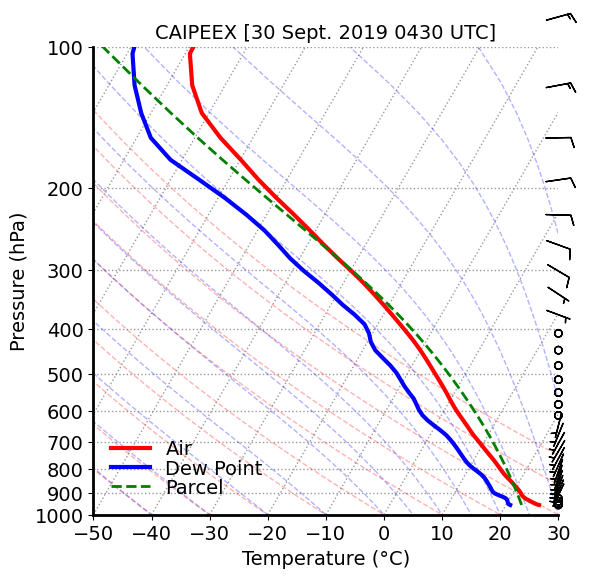

In [101]:

ds_skewt = ds_4sip.sel(time=ds_4sip.time[9])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ', parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 30)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('CAIPEEX [30 Sept. 2019 0430 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

In [111]:
# Flight data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/aa_CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_v2.columns = ['time', 'alt', 'lon', 'lat', 'air_speed', 
                   'air_temp', 'pres', 'rel_hum', 'wind_speed', 'wind_dir',
                   'vert_vel', 'num_conc_ccp_cdp', 'lwc_conc_ccp_cdp', 'mean_vol_diam_ccp_cdp', 'ccn200ass',
                   'ccn200anumconc', 'ccn200bss', 'ccn200bnumconc', 'num_conc_cdp', 'lwc_conc_cdp',
                   'mean_vol_diam_cdp', 'num_conc_cip', 'lwc_conc_cip', 'mean_vol_diam_cip', 'num_conc_pcasp',
                   'mass_conc_pcasp', 'mean_vol_diam_pcasp', 'num_conc_pip', 'lwc_conc_pip', 'mean_vol_diam_pip', 
                   'num_conc_sp2', 'mass_conc_sp2', 'mean_vol_diam_sp2', 'num_conc_sp2rbc', 'mass_conc_sp2rbc',  
                   'mean_vol_diam_sp2rbc', 'num_conc_uhsas', 'mass_conc_uhsas', 'mean_vol_diam_uhsas', 'lwc_300']

#df_v2 = pd.DataFrame(data_v2)
#df_v2['num_conc_cip'] = pd.to_numeric(df_v2['num_conc_cip'], errors='coerce')
data_v2['tempc'] = data_v2['air_temp']
ds_v2 = data_v2

ds_v2.pres[ds_v2.pres < 0.] = np.nan

/tmp/ipykernel_274504/2353124618.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_v2.pres[ds_v2.pres < 0.] = np.nan


<xarray.DataArray 'time' ()>
array('2019-09-30T09:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-30T09:00:00
Attributes:
    standard_name:  time
    axis:           T
CAPE ::  1445.9489187253037 joule / kilogram
CIN ::  0 joule / kilogram


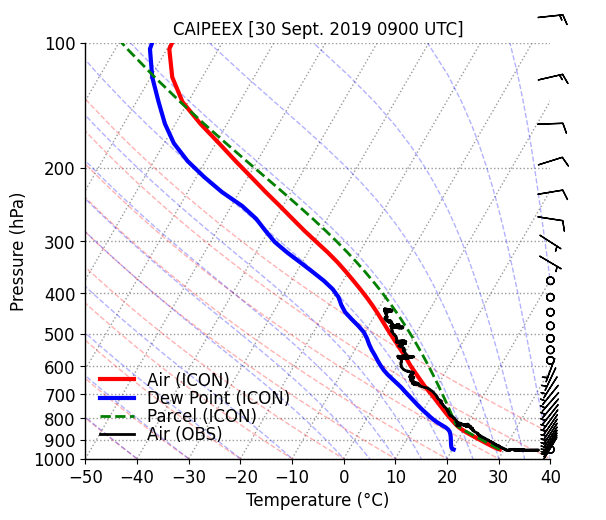

In [133]:
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from metpy.calc import parcel_profile
from metpy.calc import cape_cin

ds_skewt = ds_4sip.sel(time=ds_4sip.time[18])

print(ds_4sip.time[18])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

### Parcel properties from ICON
temperature_K = (avg_tempc + 273.15) * units.K
relative_humidity = avg_rh / 100.0  # Convert to fraction

dewpoint = dewpoint_from_relative_humidity(temperature_K, relative_humidity)
avg_dewtempc = dewpoint.magnitude #- 273.15

pressure = avg_pres * units.hPa
temperature = avg_tempc * units.degC
dewpoint = avg_dewtempc * units.degC

parcel_tempk = parcel_profile(pressure, temperature[0], dewpoint[0])  # First level
parcel_tempc = parcel_tempk.magnitude-273.15

parcel_tempc = parcel_tempc * units.degC
cape, cin = cape_cin(pressure, temperature, dewpoint, parcel_tempc)

print('CAPE :: ', cape)
print('CIN :: ', cin)
### End parcel properties


# Create the Skew-T plot
fontsize=12;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, parcel_tempc, 'g--', label='Parcel (ICON)', linewidth=lnwdth-1)
skew.plot(ds_v2.pres[8000:], ds_v2.tempc[8000:], 'k-', label='Air (OBS)', linewidth=lnwdth-1)

# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 40)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('CAIPEEX [30 Sept. 2019 0900 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.show()

In [113]:


ds_skewt = ds_4sip.sel(time=ds_4sip.time[16])

print(ds_4sip.time[16])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ', parcel_cape)
#------

<xarray.DataArray 'time' ()>
array('2019-09-30T08:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-30T08:00:00
Attributes:
    standard_name:  time
    axis:           T
CAPE ::  0.0


/tmp/ipykernel_274504/3554861184.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_v2.pres[ds_v2.pres < 0.] = np.nan


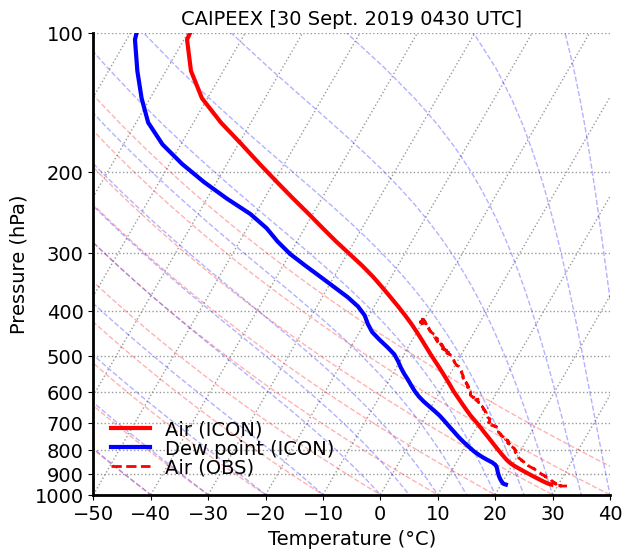

In [114]:
# Flight data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/aa_CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_v2.columns = ['time', 'alt', 'lon', 'lat', 'air_speed', 
                   'air_temp', 'pres', 'rel_hum', 'wind_speed', 'wind_dir',
                   'vert_vel', 'num_conc_ccp_cdp', 'lwc_conc_ccp_cdp', 'mean_vol_diam_ccp_cdp', 'ccn200ass',
                   'ccn200anumconc', 'ccn200bss', 'ccn200bnumconc', 'num_conc_cdp', 'lwc_conc_cdp',
                   'mean_vol_diam_cdp', 'num_conc_cip', 'lwc_conc_cip', 'mean_vol_diam_cip', 'num_conc_pcasp',
                   'mass_conc_pcasp', 'mean_vol_diam_pcasp', 'num_conc_pip', 'lwc_conc_pip', 'mean_vol_diam_pip', 
                   'num_conc_sp2', 'mass_conc_sp2', 'mean_vol_diam_sp2', 'num_conc_sp2rbc', 'mass_conc_sp2rbc',  
                   'mean_vol_diam_sp2rbc', 'num_conc_uhsas', 'mass_conc_uhsas', 'mean_vol_diam_uhsas', 'lwc_300']

#df_v2 = pd.DataFrame(data_v2)
#df_v2['num_conc_cip'] = pd.to_numeric(df_v2['num_conc_cip'], errors='coerce')
data_v2['tempc'] = data_v2['air_temp']
ds_v2 = data_v2

ds_v2.pres[ds_v2.pres < 0.] = np.nan



# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 6))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew point (ICON)', linewidth=lnwdth)

skew.plot(ds_v2.pres[1:2000], ds_v2.tempc[1:2000], 'r--', label='Air (OBS)', linewidth=lnwdth-1)
#skew.plot(ds_v2.pres[1:3000], calc_dewpoint(ds_v2.tempc[1:3000], ds_v2.rel_hum[1:3000]), 'b--', label='Dew point (OBS)', linewidth=lnwdth)

#skew.plot(ds_v2.pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
#if 'u' in ds_skewt and 'v' in ds_skewt:
#    u_wind = avg_u  # Zonal wind component
#    v_wind = avg_v  # Meridional wind component
#    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 40)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('CAIPEEX [30 Sept. 2019 0430 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()